### DeepFake vs Real
#### Exploring if there are detectable differences between a Deepfake and real Video by comparing structure similarity scores between sequential frames
by Thomas Karba (310)247-9541

In [21]:
import os
os.chdir(r'C:\Users\thoma\OneDrive\Desktop\my DS work\Queen')
import numpy as np
import cv2

Create images from Video

In [23]:
vidcap = cv2.VideoCapture('real.mkv')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

move frames to folder in directory...

In [23]:
vidcap = cv2.VideoCapture('deepfake.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

move frames to folder in directory...

### Crop Images to only include Face x2

Create Image Paths list, Change directory to proper location for both Video Frames

In [24]:
from os import listdir
path = r'C:\Users\thoma\OneDrive\Desktop\my DS work\Queen\real_frames'
files = listdir(path)
image_list = []
for image in files:
    total_path = "\\".join([path,image])
    image_list.append(total_path)

Load Deep Neural Net model to crop image to only face

In [25]:
net = cv2.dnn.readNetFromCaffe(r"C:\Users\thoma\OneDrive\Desktop\Sites\CallTextMe\FaceDetection\master\fd\deploy.prototxt.txt",
                               r"C:\Users\thoma\OneDrive\Desktop\Sites\CallTextMe\FaceDetection\master\fd\res10_300x300_ssd_iter_140000.caffemodel")
count=0
for image in image_list:
    image = cv2.imread(image)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0,(300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    #for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, 0, 2]
    if confidence < .25:
        count += 1
        continue
    else:
        box = detections[0,0,0,3:7]*np.array([w,h,w,h])
        (startx,starty,endx,endy)=box.astype("int")
        crop_img = image[starty:endy, startx:endx]
        cv2.imwrite("cropped%d.jpg" % count, crop_img)
        count += 1
        #cv2.imshow("cropped",crop_img)
        #cv2.waitKey(0)

Code for loop to grayscale and compute structural similarity for 1 pair of sequential images

In [28]:
import cv2
# load the two input images
imageA = cv2.imread(r"C:\Users\thoma\OneDrive\Desktop\my DS work\Queen\deepfake_crop\cropped4.jpg")
imageB = cv2.imread(r"C:\Users\thoma\OneDrive\Desktop\my DS work\Queen\deepfake_crop\cropped5.jpg")
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
print(grayA.shape,grayB.shape)

(133, 99) (130, 99)


In [30]:
from skimage.metrics import structural_similarity as ss

(score, diff) = ss(grayA[:130,:], grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.8745263587821754


Create list with paths to all the cropped faces

In [31]:
from os import listdir
path = r'C:\Users\thoma\OneDrive\Desktop\my DS work\Queen\deepfake_crop'
files = listdir(path)
image_list = []
for image in files:
    total_path = "\\".join([path,image])
    image_list.append(total_path)

Find the minimum image sizes in the cropped faces for the structural similarity function, which requires images to be the same size. The images will be sliced to fit one another

In [38]:
import pandas as pd
df=pd.DataFrame(data={"A":[None],"B":[None]})
for image in image_list:
    read = cv2.imread(image)
    gray = cv2.cvtColor(read, cv2.COLOR_BGR2GRAY)
    a,b = gray.shape
    df = df.append({"A":a,"B":b},ignore_index=True)

In [45]:
df[["A","B"]].min()

A    116.0
B     96.0
dtype: float64

Compute and create a datframe of scores, from one image to the next for the deepfake video frames

In [47]:
import pandas as pd
from skimage.metrics import structural_similarity as ss

scores=pd.DataFrame(data={"SSIM":[None]})
for i in range(0,len(image_list)):
    pathA = image_list[i]
    try:
        pathB = image_list[i+1]
    except IndexError:
        break
    imageA = cv2.imread(pathA)
    imageB = cv2.imread(pathB)
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    (score, diff) = ss(grayA[:116,:96], grayB[:116,:96], full=True)
    #diff = (diff * 255).astype("uint8")
    scores = scores.append({"SSIM":score},ignore_index=True)
    

In [50]:
scores['SSIM'].describe()

count    883.000000
mean       0.809946
std        0.229199
min        0.249284
25%        0.782197
50%        0.916632
75%        0.967253
max        1.000000
Name: SSIM, dtype: float64

Find the minimum image dimensions for all the cropped real face images

In [51]:
from os import listdir
path = r'C:\Users\thoma\OneDrive\Desktop\my DS work\Queen\real_crop'
files = listdir(path)
image_list = []
for image in files:
    total_path = "\\".join([path,image])
    image_list.append(total_path)
import pandas as pd
df=pd.DataFrame(data={"A":[None],"B":[None]})
for image in image_list:
    read = cv2.imread(image)
    gray = cv2.cvtColor(read, cv2.COLOR_BGR2GRAY)
    a,b = gray.shape
    df = df.append({"A":a,"B":b},ignore_index=True)
df[["A","B"]].min()

A    81.0
B    67.0
dtype: float64

Compute and create a datframe of scores, from one image to the next for the real video frames

In [53]:
import pandas as pd
from skimage.metrics import structural_similarity as ss

scores_real=pd.DataFrame(data={"SSIM":[None]})
for i in range(0,len(image_list)):
    pathA = image_list[i]
    try:
        pathB = image_list[i+1]
    except IndexError:
        break
    imageA = cv2.imread(pathA)
    imageB = cv2.imread(pathB)
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    (score, diff) = ss(grayA[:81,:67], grayB[:81,:67], full=True)
    #diff = (diff * 255).astype("uint8")
    scores_real = scores_real.append({"SSIM":score},ignore_index=True)

### compare the Structural Similarity scores of both videos

In [54]:
scores['SSIM'].describe() # DEEPFAKE of QUEEN

count    883.000000
mean       0.809946
std        0.229199
min        0.249284
25%        0.782197
50%        0.916632
75%        0.967253
max        1.000000
Name: SSIM, dtype: float64

In [55]:
scores_real['SSIM'].describe() # REAL QUEEN

count    839.000000
mean       0.849257
std        0.126434
min        0.523660
25%        0.719828
50%        0.906436
75%        0.952260
max        1.000000
Name: SSIM, dtype: float64

Because the Videos have a different length of frames, 
both dataframes will be limited to a similar size in order
to do a T-Test

In [68]:
fake,real = scores[1:840]['SSIM'].values,scores_real[1:]['SSIM'].values

fake.shape,real.shape

((839,), (839,))

Plotting the scores for both videos as to compare the approximate Variance between them

Text(0.5, 1.0, 'Real:  Seq. Similarity')

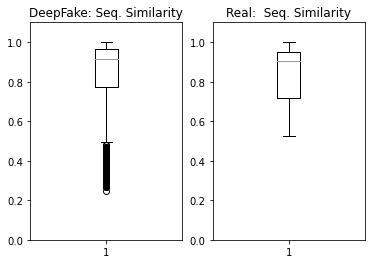

In [79]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.boxplot(fake)
plt.ylim(0,1.1)
plt.title("DeepFake: Seq. Similarity")
plt.subplot(1,2,2)
plt.boxplot(real)
plt.ylim(0,1.1)
plt.title("Real:  Seq. Similarity")

Many more outliers in the DeepFake scores, as well as a tighter distribution as evident by the differences between the 25th and 75th percentile

Perform a T-test with equal Variances

In [71]:
from scipy import stats
stats.ttest_ind(fake,real,equal_var=True)

Ttest_indResult(statistic=-4.548219206286324, pvalue=5.798614320572615e-06)

#### *There is sufficient evidence to confirm there is statistically significant difference between the mean structure similary of the DeepFake Queen video and the structure similarity of the Real Queen video (p-value:5.7e-6 from T-test).*

This confirms there are detectable differences between a real video of a face and a computer generated video of a face. 
The scope of this project is limited however to just two videos or one pair - using Queen Elisabeth deepfake and a real video. More sample-pairs need to be explored.